# Prédiction des IC50
Objectif : Prédire les IC50 des molécules récupérées par similarité de structure sur la protéine d'intérêt

## Prérequis

In [1]:
!pip install rdkit &> /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pickle import load

from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()


import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
import matplotlib.pyplot as plt

from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

from urllib.parse import quote

import pandas as pd
import numpy as np
import requests
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [4]:
from matplotlib.axis import YAxis
# Fonction pour calculer l'empreinte d'un molécule à partir de sa structure smiles
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

# Fonction pour construire le réseau de neurones
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

# Fonction pour obtenir le CID d'un composé à partir de son identifiant SMILES
def query_pubmed_cidFromSmiles(smiles):
    """
    Query PubChem for CID of a SMILES sting.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{escaped_smiles}/cids/JSON"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["IdentifierList"]["CID"][0]
    if key == "0" :
      return("None")
    else :
      return key
  
# Fonction pour obtenir les références de brevets pour un composé
def query_patent_cid(cid):
    """
    Query PubChem for CID of a SMILES sting.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    try :
      url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/xrefs/PatentID/JSON"
      r = requests.get(url)
      r.raise_for_status()
      y = r.json()["InformationList"]["Information"]
      y = y[0].get("PatentID")
    except :
      y = "None"

    return y

## Chargement des données

In [5]:
# Récupération de l'identifiant uniprot
with open("/content/drive/MyDrive/Colab Notebooks/these_exercice/output/01_compoundDataAcquisition/uniprot_id.txt", "rb") as file:
    uniprot_id = load(file)
print(uniprot_id)
# Récupération de toutes les molécules ayant des valeurs de pIC50 pour la protéine d'intérêt
prot_molecules = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/these_exercice/output/01_compoundDataAcquisition/{uniprot_id}_compounds.csv")
# Récupération des molécules sélectionnées pour leur interaction avec la protéine cible
firstMolecules = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/these_exercice/output/03_molecularSubstructureFiltering/"+uniprot_id+".csv")
# Récupération des molécules sélectionnées pour leur similarités de structures avec le premier 
# set de molécules
secondMolecules = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/these_exercice/output/06_similarCompoundMolecularFiltering/"+uniprot_id+"_ro5Compliant.csv")

print(firstMolecules.shape)
print(secondMolecules.shape)

P08581
(1308, 10)
(53129, 6)


## Entrainement du modèle
### Encodage de la structure moléculaire

In [6]:
firstMolecules["fingerprints_df"] = firstMolecules["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", firstMolecules.shape)
firstMolecules.head(3)

Shape of dataframe: (1308, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,lipinski,fingerprints_df
0,CHEMBL3582305,0.13,nM,CNC(=O)c1ccc(-c2cnc3nnc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,413.140036,7,1,2.8240,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3188267,0.13,nM,CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,412.144787,6,1,3.4290,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3797911,0.19,nM,COc1ccc2c(OCc3nnc4ncc(-c5ccccc5)nn34)ccnc2c1,9.721246,384.133474,8,0,3.3221,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
len(firstMolecules.loc[902,"fingerprints_df"])

167

### Préparation des données d'entrainement et de test

In [ ]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    firstMolecules["fingerprints_df"], firstMolecules[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (915,)
Shape of test data: (393,)


## Entrainement du modèle

In [ ]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

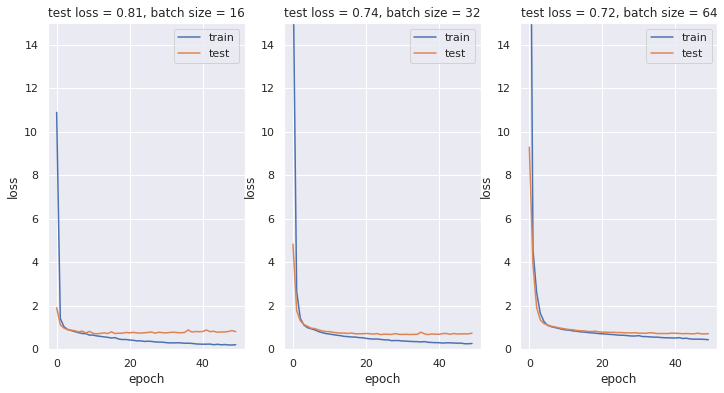

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

In [ ]:
# Save the trained model
filepath = "/content/drive/MyDrive/Colab Notebooks/these_exercice/output/07_predictIC50/best_weights.hdf5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

In [ ]:
# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=64,
    callbacks=callbacks_list,
    verbose=0,
)

## Evaluation et prédiction

In [ ]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 0.78
 mse (same as loss): 0.78
 mae: 0.65


In [ ]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

13/13 [==============================] - 0s 1ms/step
5.44
7.08
7.52
6.86
6.73


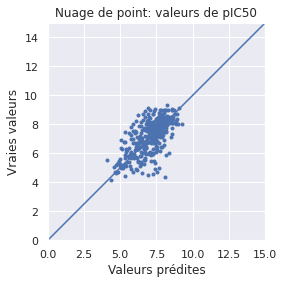

In [ ]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Valeurs prédites")
ax.set_ylabel("Vraies valeurs")
ax.set_title("Nuage de point: valeurs de pIC50")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

## Prédiction de l'IC50 des molécules récupérée sur PubMed
### Encodage de la structure moléculaire

In [ ]:
secondMolecules["fingerprint_df"] = secondMolecules["smiles"].apply(smiles_to_fp)

### Prédiction des IC50

In [ ]:
# Prediction on external/unlabeled data
predictions = model.predict(
    np.array(list((secondMolecules["fingerprint_df"]))).astype(float), callbacks=callbacks_list)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_pIC50"])
predicted_pIC50_df = secondMolecules.join(predicted_pIC50)

predicted_pIC50_df.head(3)

1661/1661 [==============================] - 2s 1ms/step


,smiles,molecular_weight,n_hba,n_hbd,logp,lipinski,fingerprint_df,predicted_pIC50
0,C1COCCN1CCCCC(=O)NC2=CC=C(C=C2)C3=CN=CC=C3.Cl,375.171355,4.0,1.0,3.6114,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.084804
1,C1CCC(CC1)CCC(C(=O)N)NC(=O)C2=CC=C(C=C2)CNC(=O...,502.269239,6.0,4.0,3.3287,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.764895
2,C1CC1C2=CC(=NN2)NC3=NC(=NC=C3)NC4=CC5=C(C=C4)N...,332.149793,6.0,4.0,3.4406,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.847225


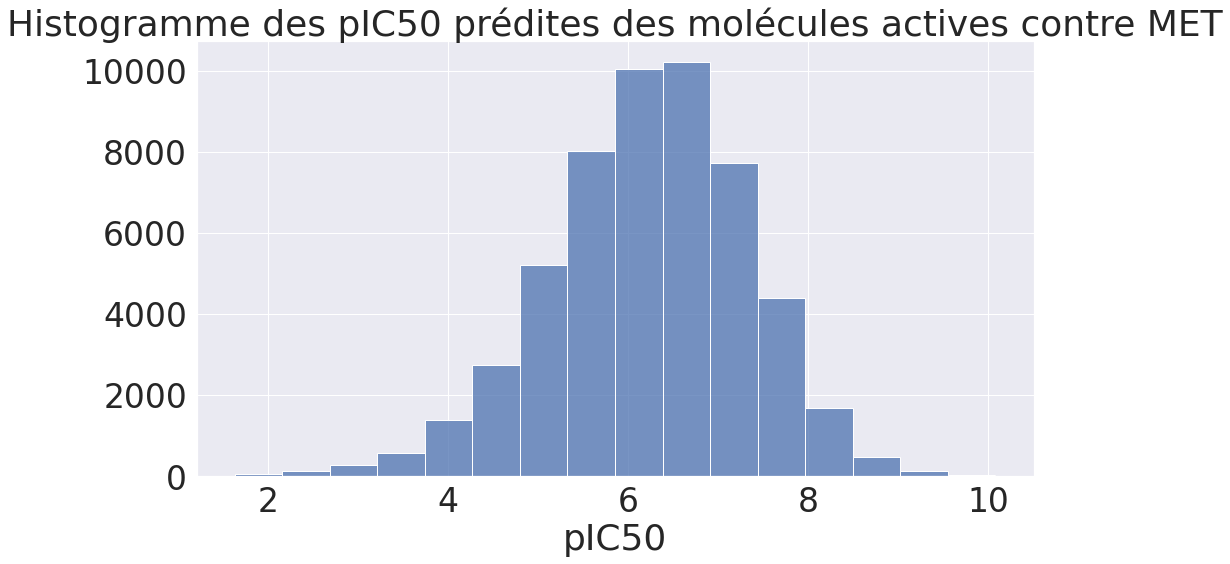

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("white")
sns.set(font_scale=3)
fig = sns.histplot(predicted_pIC50_df, x="predicted_pIC50",bins = int(1+3.322*np.log10(predicted_pIC50_df.shape[0])))
fig.set(xlabel="pIC50", ylabel=None)
fig.tick_params(bottom=False)
plt.title("Histogramme des pIC50 prédites des molécules actives contre MET")
plt.show()

## Filtrage des molécules sur la base de leur IC50
On ne garde que les molécules avec une IC50 inférieur au nM

In [ ]:
predicted_pIC50_df[predicted_pIC50_df.predicted_pIC50 > 9].sort_values("predicted_pIC50", ascending = False).shape

(89, 8)

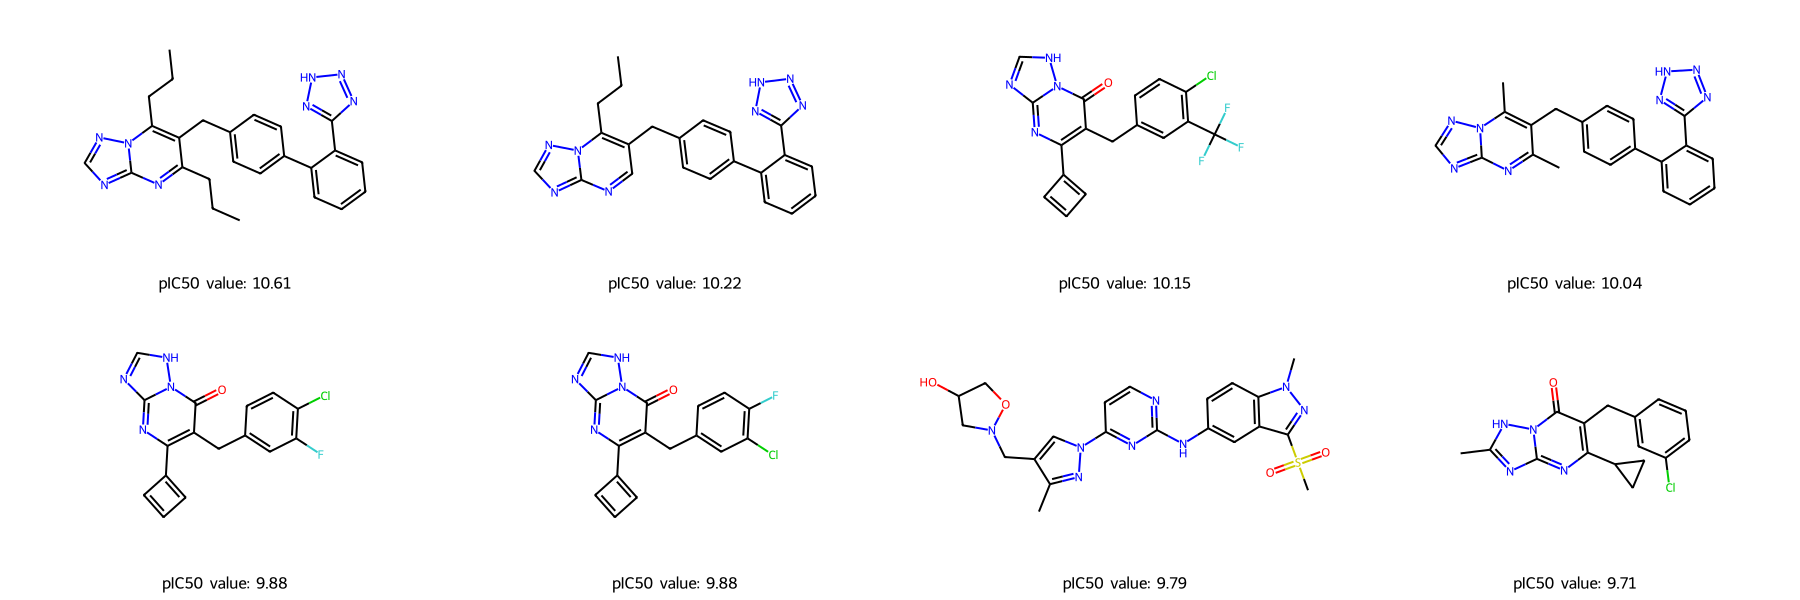

In [ ]:
threshold_pIC50 = 9
pIC50_inf = predicted_pIC50_df[predicted_pIC50_df.predicted_pIC50 > threshold_pIC50].sort_values("predicted_pIC50", ascending = False)
# Affichage des molécules
highest_pIC50 = pIC50_inf["smiles"]

mols_protein = [Chem.MolFromSmiles(smile) for smile in pIC50_inf.smiles]
pIC50_protein = pIC50_inf["predicted_pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_protein]

Draw.MolsToGridImage(mols_protein[0:8], molsPerRow=4, subImgSize=(450, 300), legends=pIC50_values[0:10])

## Récupération des CID pour les molécules

In [ ]:
pIC50_inf.shape

(89, 8)

In [ ]:
pIC50_inf["cid"] = pIC50_inf["smiles"].progress_apply(query_pubmed_cidFromSmiles)
pIC50_inf["patentID"] = pIC50_inf.cid.progress_apply(query_patent_cid)

100%|██████████| 89/89 [00:14<00:00,  6.09it/s]


In [ ]:
pIC50_inf.shape

(89, 10)

In [ ]:
pIC50_inf.head()

,smiles,molecular_weight,n_hba,n_hbd,logp,lipinski,fingerprint_df,predicted_pIC50,cid,patentID
33432,CCCC1=C(C(=NC2=NC=NN12)CCC)CC3=CC=C(C=C3)C4=CC...,438.228043,7.0,1.0,4.46720,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.609104,3074928,"[CA-2128876-C, CZ-204494-A3, CZ-282075-B6, JP-..."
4329,CCCC1=C(C=NC2=NC=NN12)CC3=CC=C(C=C3)C4=CC=CC=C...,396.181093,7.0,1.0,3.51470,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.221253,3074929,"[CZ-282075-B6, HU-220392-B, JP-3372040-B2, US-..."
25189,C1=CC(=C1)C2=C(C(=O)N3C(=N2)N=CN3)CC4=CC(=C(C=...,378.049523,4.0,1.0,3.63380,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.152609,67415689,[WO2011114148A1]
14163,CC1=C(C(=NC2=NC=NN12)C)CC3=CC=C(C=C3)C4=CC=CC=...,382.165443,7.0,1.0,3.17904,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.036839,3074905,"[CA-2128876-C, CZ-204494-A3, CZ-282075-B6, HU-..."
51533,C1=CC(=C1)C2=C(C(=O)N3C(=N2)N=CN3)CC4=CC(=C(C=...,328.052717,4.0,1.0,2.75410,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",9.882215,67415089,[WO2011114148A1]


In [ ]:
pIC50_inf.to_csv(f"/content/drive/MyDrive/Colab Notebooks/these_exercice/output/07_predictIC50/mol_pIC50sup{threshold_pIC50}_{uniprot_id}.csv", index = False)